Практическое задание:
- взять любой набор данных для бинарной классификации (https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_csv("breast-cancer.csv")
df.diagnosis.replace({"M": 1, "B": 0}, inplace=True)
df.drop(columns="id", inplace=True)
print(df.shape)
df.head(3)

(569, 31)


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


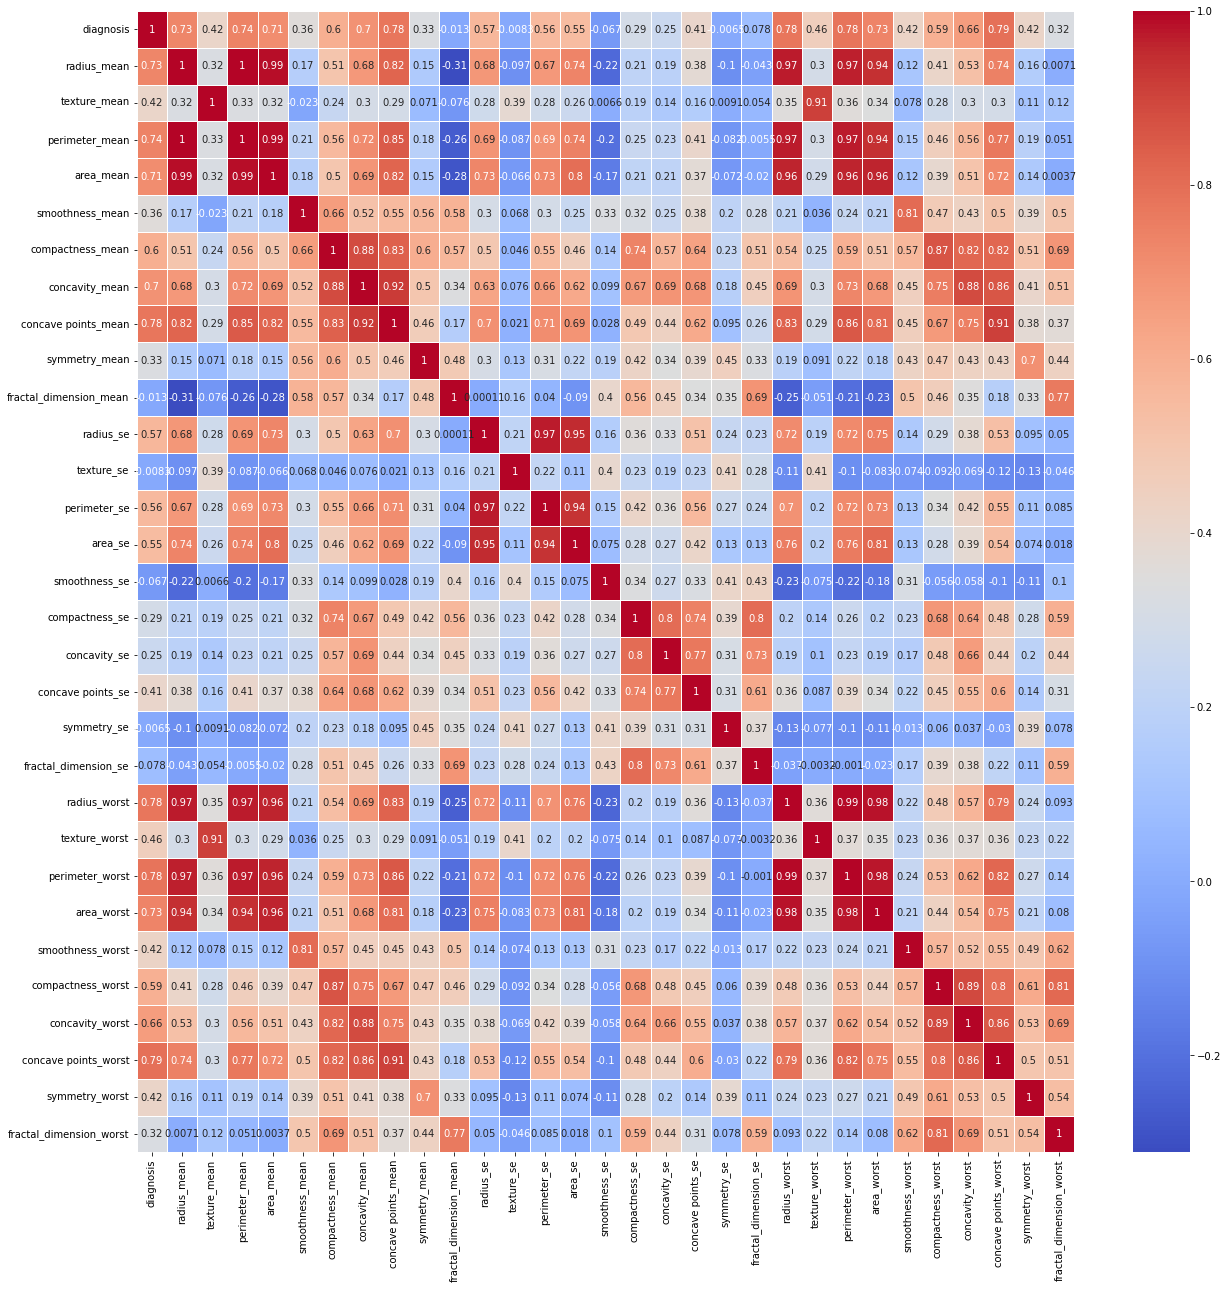

In [17]:
fig = plt.figure(figsize=(21, 21)) 
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, linewidth=0.5)
plt.show()

In [18]:
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
target = 'diagnosis'

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

In [19]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [20]:
continuous_columns = features
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [21]:
clf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [22]:
#обучим наш пайплайн
clf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('radius_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='radius_mean')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('texture_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='texture_mean')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('perimeter_mean',
                                                 Pipeline(steps=[('selector',
        

In [23]:
y_pred = clf.predict(X_test)

In [27]:
def evaluate_results(y_test, y_pred):
    print('Classification results:')
    f1 = f1_score(y_test, y_pred)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_pred)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_pred, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_pred, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

In [28]:
evaluate_results(y_test, y_pred)

Classification results:
f1: 96.30%
roc: 97.39%
recall: 98.11%
precision: 94.55%


Посмотрим на важность признаков:

In [34]:
features = pd.DataFrame(clf[1].feature_importances_, 
                        X_train.columns, 
                        columns=['coefficient']).sort_values(by=['coefficient'], ascending=False)

In [35]:
features

,coefficient
area_worst,0.154012
concave points_worst,0.121658
concave points_mean,0.105404
perimeter_worst,0.092710
concavity_mean,0.065273
radius_worst,0.060749
radius_mean,0.055807
perimeter_mean,0.055577
area_se,0.042099
area_mean,0.037738


In [36]:
import shap

# load JS visualization code to notebook
shap.initjs()

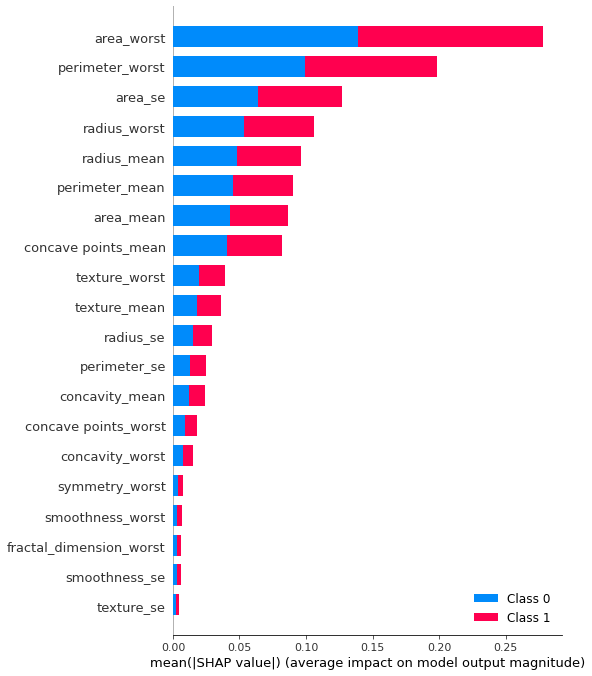

In [41]:
explainer = shap.TreeExplainer(clf[1])
shap_values = explainer.shap_values(X_train)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values, X_train)

In [42]:
shap.force_plot(explainer.expected_value[0], shap_values[0][25],  X_train.iloc[25,:])